In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
def plot_gait_cycle(df, df_movement, movement):
    # Set the font to Arial
    plt.rcParams['font.family'] = 'Arial'

    # Set the size of the plot
    plt.figure(figsize=(10, 6), dpi=300)

    # Plot the data
    plt.plot(df['Time_Percentage'], df['Angle'], label='Prosthesis')
    plt.plot(df_movement['Time'], df_movement[movement], label='Reference', linestyle='--')

    # Add labels and title
    plt.xlabel('Gait Cycle (%)')
    plt.ylabel('Angle (°)')
    #plt.title('Dorsiflexion & Plantar Flexion')

    # Set X-axis ticks with a step of 10
    plt.xticks(range(0, 101, 10))

    # Set X-axis limits to 0 to 100
    plt.xlim(0, 100)

    # Add dashed vertical lines at specified percentages
    vertical_lines = [10, 30, 55, 65, 75, 85]
    for x in vertical_lines:
        plt.axvline(x=x, color='green', linestyle='--', alpha=0.35)

    # Add labels at the top of the chart between each vertical line
    labels = ['(MSt)', '(TSt)', '(PSw)', '(ISw)', '(MSw)']

    plt.text(0, df['Angle'].max() + 2.5, '(IC)', ha='center', va='bottom', fontsize=10, color='black')
    plt.text(vertical_lines[0] / 2, df['Angle'].max() + 2, '(LR)', ha='center', va='bottom', fontsize=10, color='black')
    plt.text(92.5, df['Angle'].max() + 2, '(TSw)', ha='center', va='bottom', fontsize=10, color='black')

    for i, x in enumerate(vertical_lines):
        if i < len(vertical_lines) - 1:
            mid_point = (vertical_lines[i] + vertical_lines[i + 1]) / 2
            plt.text(mid_point, df['Angle'].max() + 2, labels[i], ha='center', va='bottom', fontsize=10, color='black')

    # Add grid
    plt.grid(True)

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

## Dataframe of Vicky 3km

In [3]:
df_vicky = pd.read_excel('tobillovicky3km.xlsx')
# Keep the rows between the value 50,30 and 51,51 in Time column
df_vicky = df_vicky[(df_vicky['Time'] >= 50.3) & (df_vicky['Time'] < 51.51)]

df_vicky['Time'] = df_vicky['Time'] - 50.3

# Calculate the total time
total_time = df_vicky['Time'].max()

# Create a new column for time percentage
df_vicky['Time_Percentage'] = (df_vicky['Time']/ total_time) * 100

# Make 3 datasets: ["Time", "last colum"], ["Time", "last colum"], ["Time", "last colum"]
df_rotacion = df_vicky.iloc[:, [-1, -2]]
df_rotacion.columns = ["Time", "Rotación"]

df_eversion = df_vicky.iloc[:, [-1, -3]]
df_eversion.columns = ["Time", "Eversión"]

df_dorsiflexion = df_vicky.iloc[:, [-1, -4]]
df_dorsiflexion.columns = ["Time", "Dorsiflexión"]

df_vicky.shape

(121, 11)

## Dorsiflexion

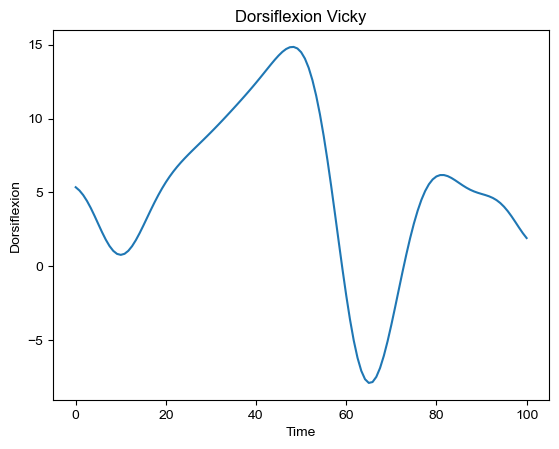

In [44]:
# Plot df_dorsiflexion
plt.plot(df_dorsiflexion['Time'], df_dorsiflexion['Dorsiflexión'])
plt.xlabel('Time')
plt.ylabel('Dorsiflexion')
plt.title('Dorsiflexion Vicky')
plt.show()

In [4]:
df = pd.read_excel('Bases/Dorsiflexion/dorsiflexion6.xlsx')
df.shape

(4058, 3)

In [5]:
tmin = 708 # 85
tmax = 2049 # 1180
df = df.loc[tmin:tmax]

# Drop de Second column
df = df.drop(df.columns[1], axis=1)

df.columns = ['Time', 'Angle']

# Adjust the time and angle
df['Time'] = df['Time'] - df['Time'][tmin]
df['Angle'] = df['Angle'] + 16

# Calculate the total time
total_time = df['Time'].max()

# Create a new column for time percentage
df['Time_Percentage'] = (df['Time']/ total_time) * 100

# Time percentage between 35 and 55
#df = df[(df['Time_Percentage'] >= 25) & (df['Time_Percentage'] < 65)]

df.shape

(1342, 3)

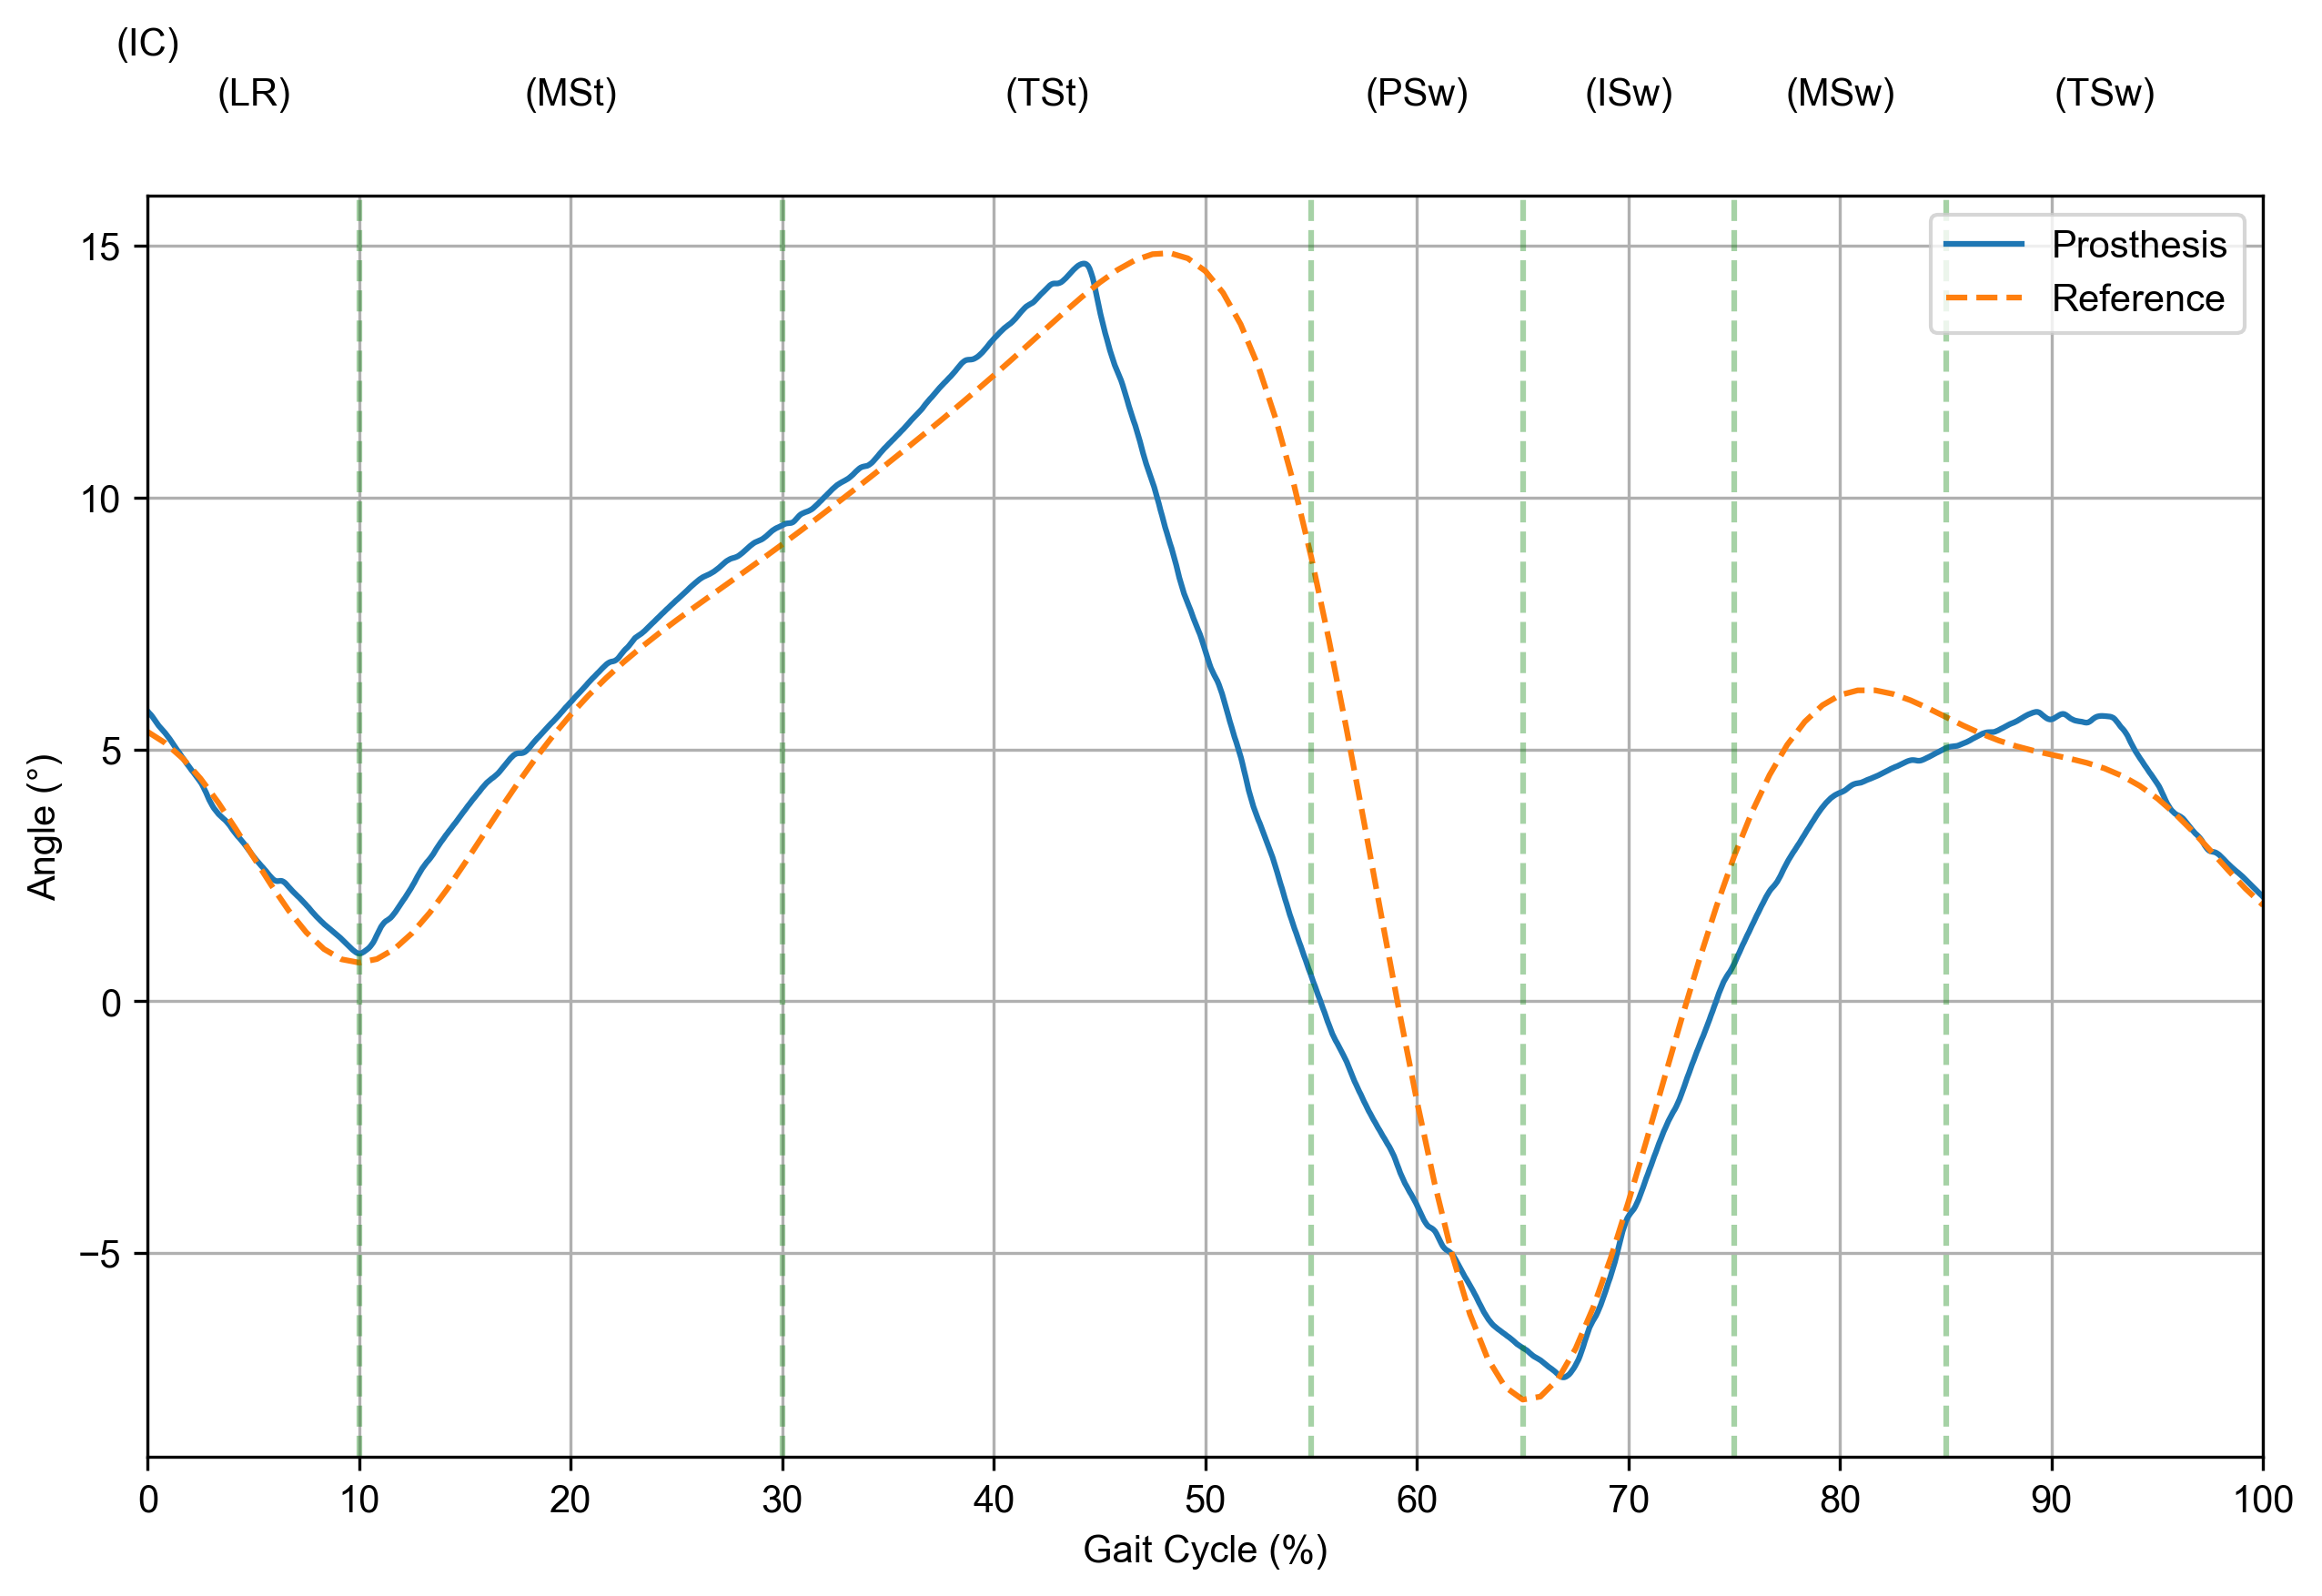

In [57]:
plot_gait_cycle(df, df_dorsiflexion, 'Dorsiflexión')

## Eversion

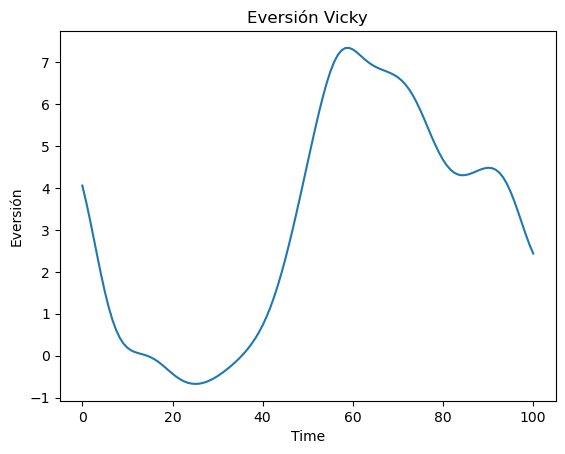

In [6]:
# Plot df_dorsiflexion
plt.plot(df_eversion['Time'], df_eversion['Eversión'])
plt.xlabel('Time')
plt.ylabel('Eversión')
plt.title('Eversión Vicky')
plt.show()

In [7]:
df = pd.read_csv('Bases/Eversion/eversion2.csv', sep=';')
df.shape

(637, 2)

In [8]:
df = pd.read_csv('Bases/Eversion/eversion2.csv', sep=';')

# Keep just the rows needed for one cycle
tmin = 293 # 248
tmax = 325 # 284
df = df.loc[tmin:tmax]

df.columns = ['Time', 'Angle']

# Adjust the time and angle
df['Time'] = df['Time'] - df['Time'][tmin] #
df['Angle'] = df['Angle'] - 119.2 #

# Calculate the total time
total_time = df['Time'].max()

# Create a new column for time percentage
df['Time_Percentage'] = (df['Time']/ total_time) * 100

# Time percentage between 35 and 55
#df = df[(df['Time_Percentage'] >= 15) & (df['Time_Percentage'] < 20)]

df.shape

(33, 3)

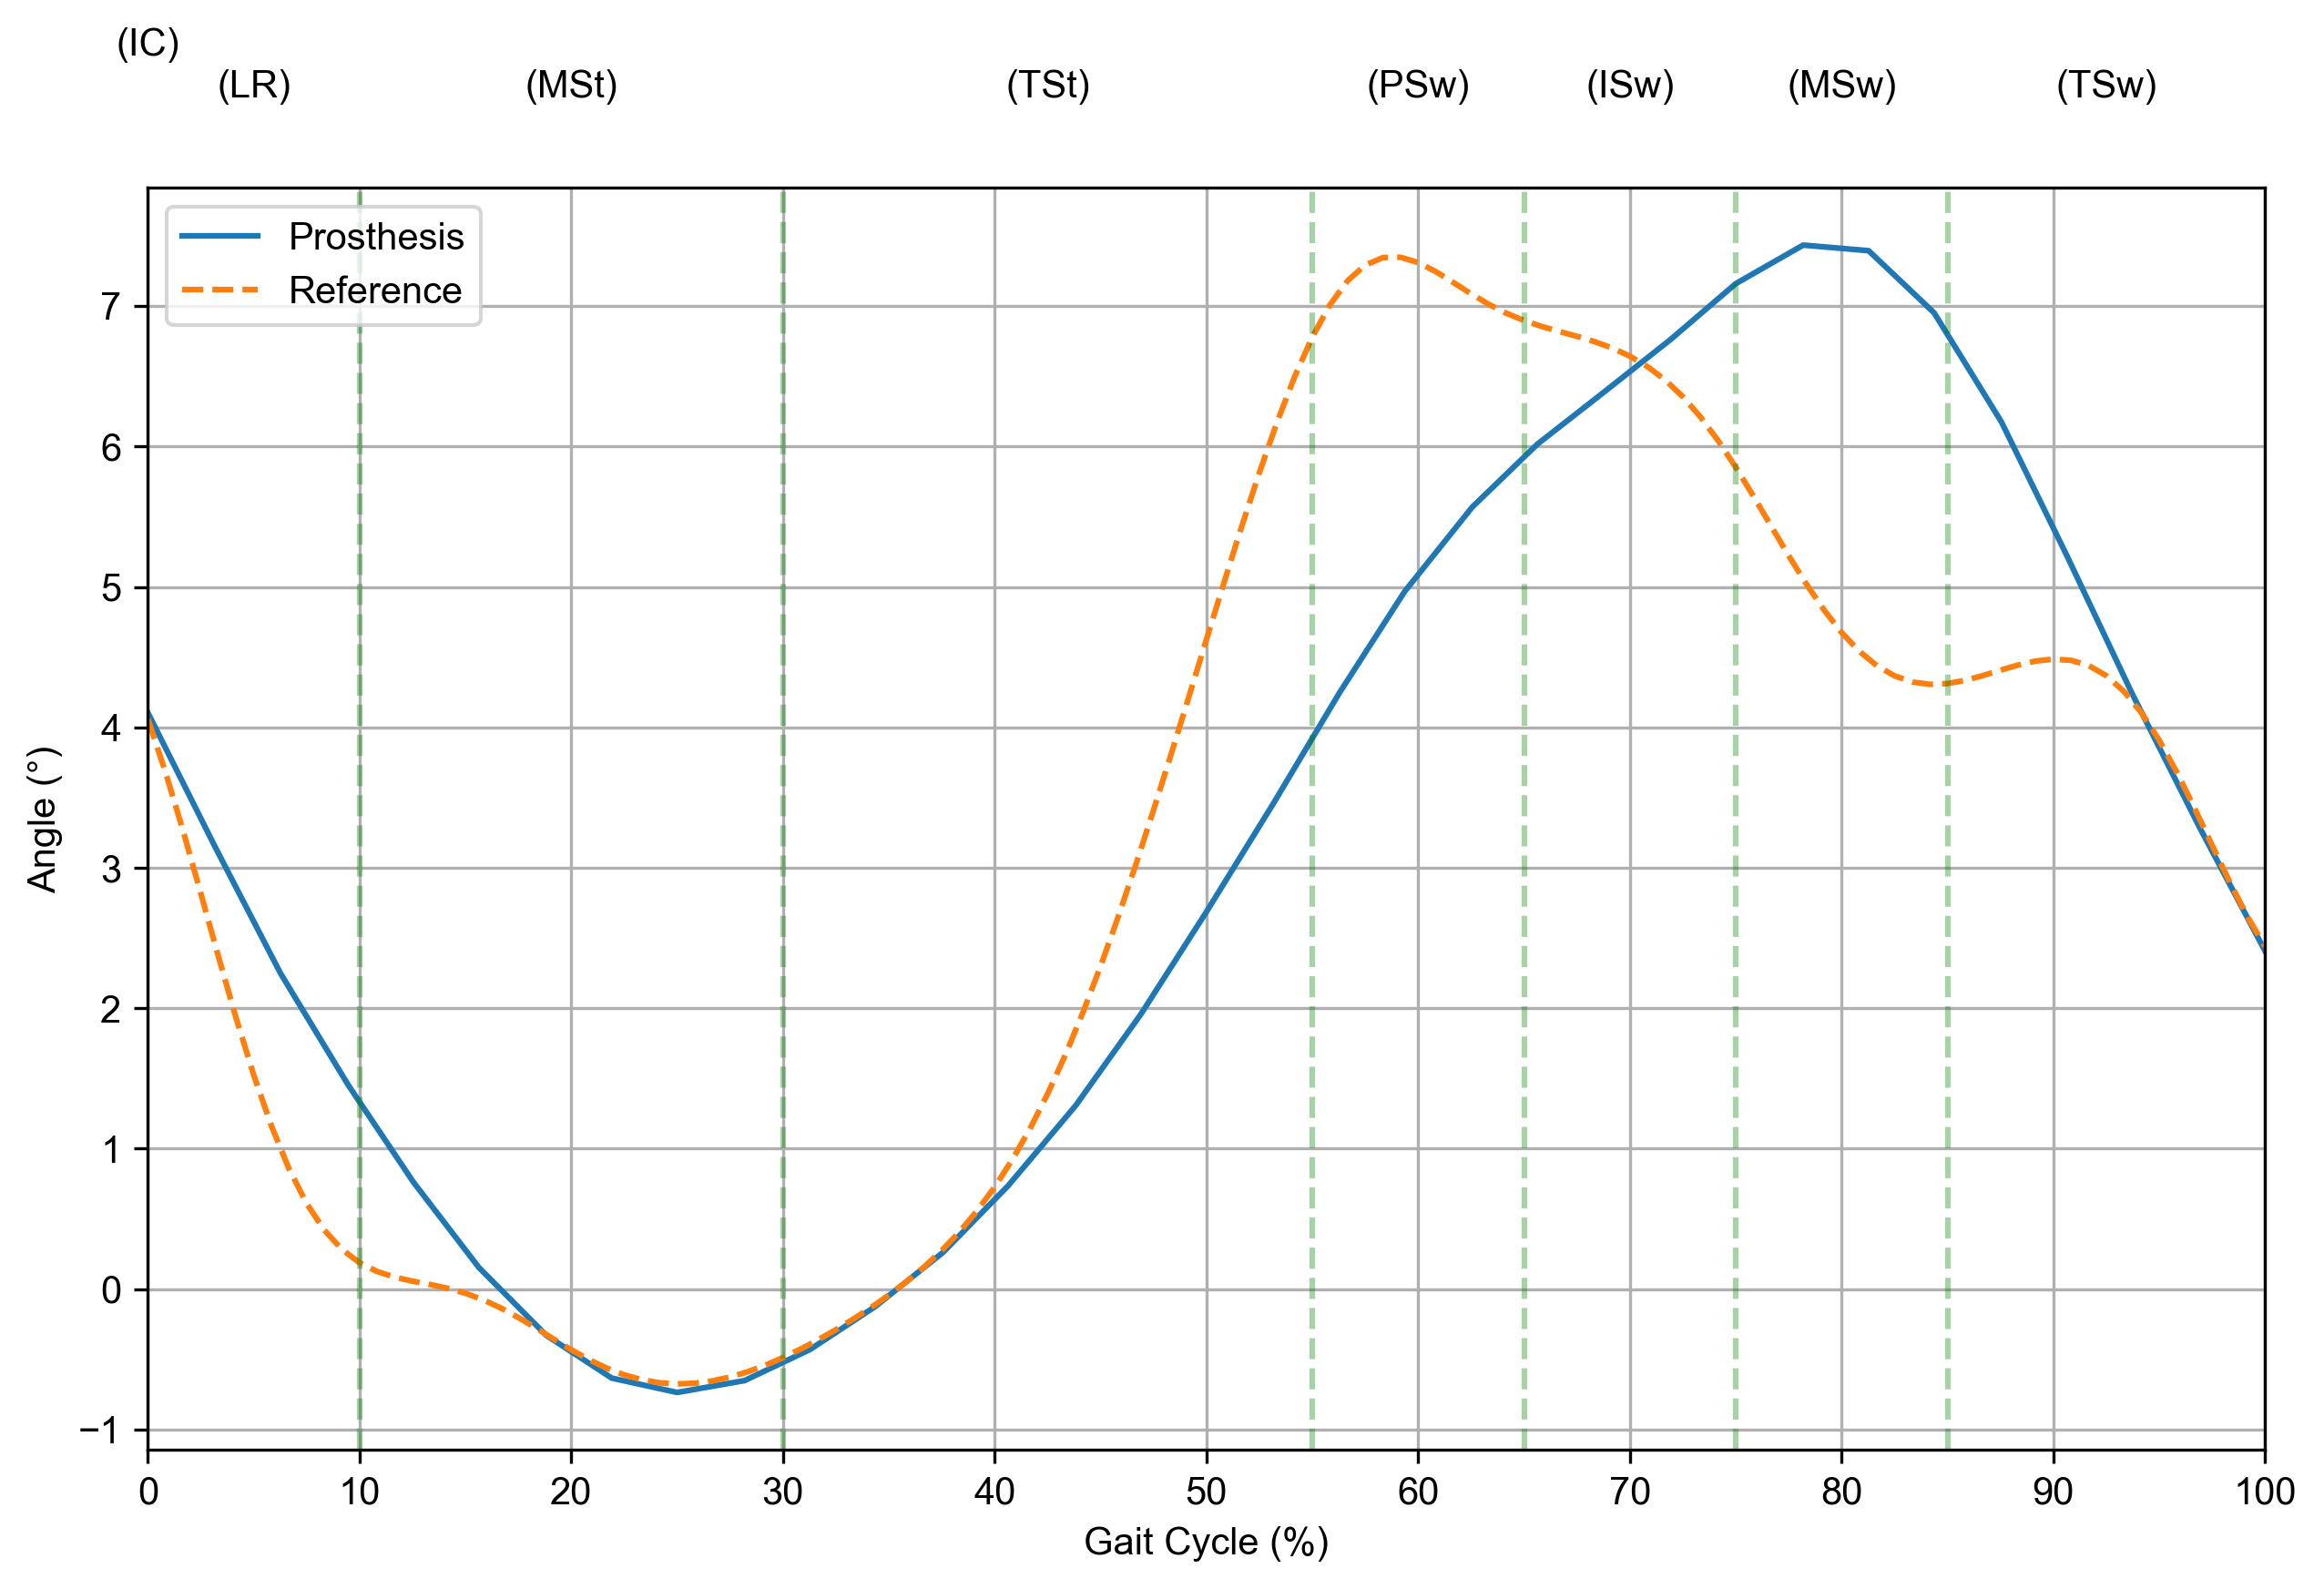

In [13]:
plot_gait_cycle(df, df_eversion, 'Eversión')

## Rotacion Interna y Externa

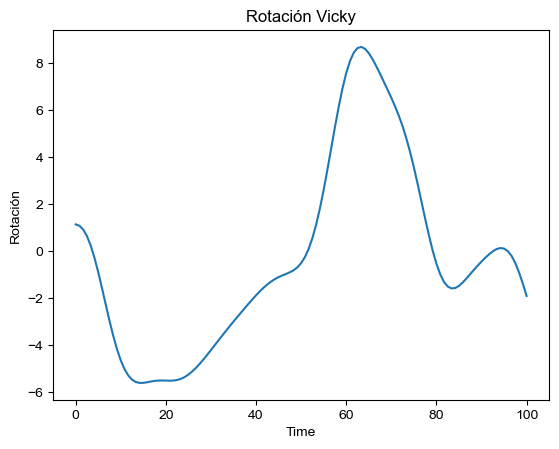

In [14]:
# Plot df_dorsiflexion
plt.plot(df_rotacion['Time'], df_rotacion['Rotación'])
plt.xlabel('Time')
plt.ylabel('Rotación')
plt.title('Rotación Vicky')
plt.show()

In [15]:
df = pd.read_csv('Bases/Rotacion/rotacion2.csv', sep=';')
df.shape

(478, 2)

In [16]:
df = pd.read_csv('Bases/Rotacion/rotacion.csv', sep=';')

# Keep just the rows needed for one cycle
tmin = 261 # 100, 126
tmax = 306 # 306
df = df.loc[tmin:tmax]

df.columns = ['Time', 'Angle']

# Adjust the time and angle
df['Time'] = df['Time'] - df['Time'][tmin] #
df['Angle'] = df['Angle'] - 6#

# Calculate the total time
total_time = df['Time'].max()

# Create a new column for time percentage
df['Time_Percentage'] = (df['Time']/ total_time) * 100

# Time percentage between 35 and 55
#df = df[(df['Time_Percentage'] >= 15) & (df['Time_Percentage'] < 20)]

df.shape

(46, 3)

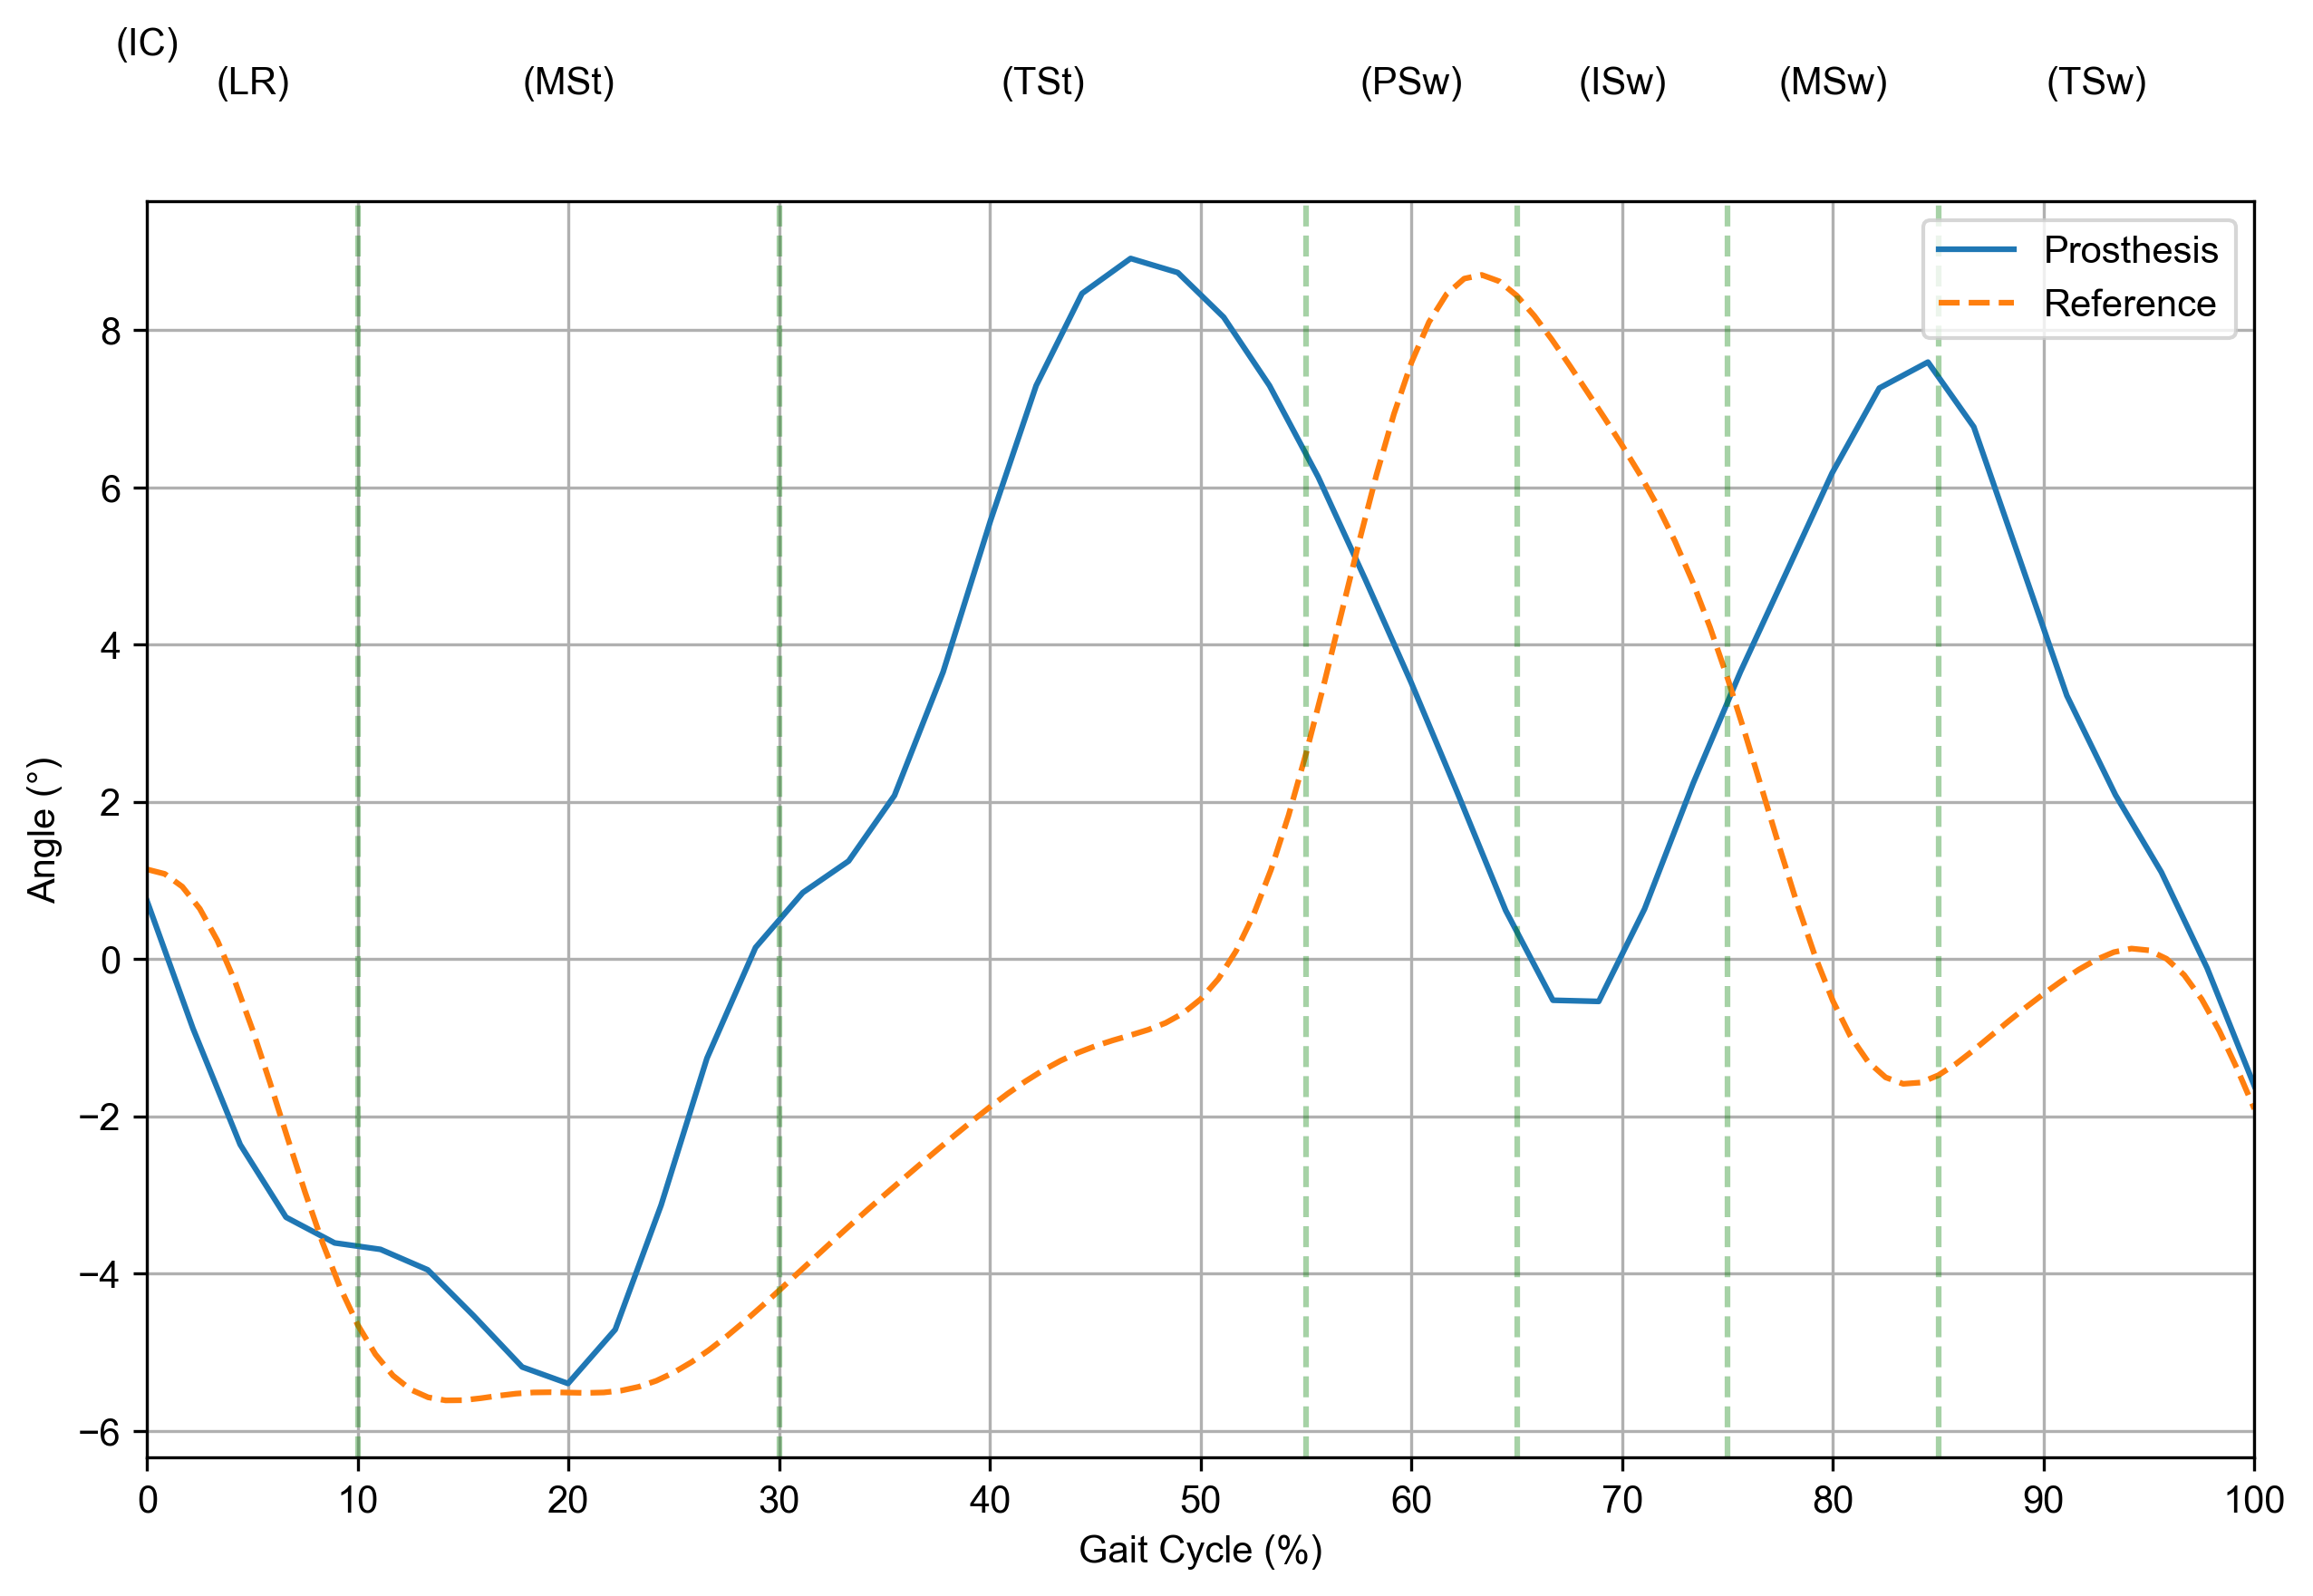

In [19]:
plot_gait_cycle(df, df_rotacion, 'Rotación')